In [11]:
import pandas as pd
import numpy as np
from itertools import product

# 1. read data
vgg_train_path = 'vgg_train.csv' 
vgg_test_path = 'vgg_test.csv'
raman_path = 'raman_data.csv'            

vgg_train = np.genfromtxt(vgg_train_path, delimiter=',')
vgg_test = np.genfromtxt(vgg_test_path, delimiter=',')
raman_data = np.genfromtxt(raman_path, delimiter=',')
vgg_data =  np.concatenate((vgg_train,vgg_test),axis=0)
vgg_data, raman_data


(array([[ 3.84079289,  3.99889517,  2.58120465, ...,  0.21158479,
         -0.96334314,  0.        ],
        [ 2.28245735,  2.88184237,  1.56598735, ...,  0.35030726,
         -0.7106269 ,  0.        ],
        [ 3.29867983,  3.63059497,  2.18886828, ..., -0.6007871 ,
         -0.73169732,  0.        ],
        ...,
        [-2.56227469,  1.86912668, -2.0904243 , ...,  4.78099966,
         -1.0768435 ,  2.        ],
        [-1.06620371,  0.45336431, -0.78523117, ...,  3.66696501,
         -0.83835495,  2.        ],
        [-1.06620371,  0.45336431, -0.78523117, ...,  3.66696501,
         -0.83835495,  2.        ]]),
 array([[-6.0815 , -4.9574 , -3.65   , ..., -1.362  , -2.2032 ,  0.     ],
        [-6.291  , 29.026  ,  2.8737 , ...,  0.0818 ,  0.19099,  0.     ],
        [ 0.31828, -3.0695 , -3.0513 , ...,  1.7729 , -1.6263 ,  0.     ],
        ...,
        [14.968  , -1.8226 , -0.1703 , ..., -0.146  ,  1.4523 ,  2.     ],
        [10.491  , -1.7913 ,  2.5144 , ..., -0.55604,  0.503

In [16]:
# remove label
vgg_no_label = vgg_data[:, :-1]
raman_data_no_label = raman_data[:, :-1]

label_vgg = vgg_data[:, -1]
label_data = raman_data[:, -1]

raman_data_no_label


array([[-6.0815e+00, -4.9574e+00, -3.6500e+00, ...,  1.7222e+00,
        -1.3620e+00, -2.2032e+00],
       [-6.2910e+00,  2.9026e+01,  2.8737e+00, ...,  3.4348e-01,
         8.1800e-02,  1.9099e-01],
       [ 3.1828e-01, -3.0695e+00, -3.0513e+00, ...,  1.7338e-02,
         1.7729e+00, -1.6263e+00],
       ...,
       [ 1.4968e+01, -1.8226e+00, -1.7030e-01, ...,  8.4968e-01,
        -1.4600e-01,  1.4523e+00],
       [ 1.0491e+01, -1.7913e+00,  2.5144e+00, ...,  1.9164e-01,
        -5.5604e-01,  5.0326e-01],
       [-2.1995e+00, -5.2685e+00, -2.7281e+00, ..., -9.3524e-01,
         7.3525e-01, -1.3474e-01]])

In [17]:
group_count_vgg = np.unique(label_vgg, return_counts=True)
group_count_data = np.unique(label_data, return_counts=True)
group_count_vgg, group_count_data


((array([0., 1., 2.]), array([675, 912, 933], dtype=int64)),
 (array([0., 1., 2.]), array([20, 20, 20], dtype=int64)))

In [18]:
# combine data
combined_data = []
combined_labels = []

for label in np.unique(label_vgg):
    if label in np.unique(label_data):
        rows_vgg = vgg_no_label[label_vgg == label]
        rows_data = raman_data_no_label[label_data == label]

        for row_vgg, row_data in product(rows_vgg, rows_data):
            combined_data.append(np.concatenate([row_vgg, row_data]))
            combined_labels.append(label)

combined_data_array = np.array(combined_data)
combined_labels_array = np.array(combined_labels)
combined_data_array

array([[ 3.84079289,  3.99889517,  2.58120465, ...,  1.7222    ,
        -1.362     , -2.2032    ],
       [ 3.84079289,  3.99889517,  2.58120465, ...,  0.34348   ,
         0.0818    ,  0.19099   ],
       [ 3.84079289,  3.99889517,  2.58120465, ...,  0.017338  ,
         1.7729    , -1.6263    ],
       ...,
       [-1.06620371,  0.45336431, -0.78523117, ...,  0.84968   ,
        -0.146     ,  1.4523    ],
       [-1.06620371,  0.45336431, -0.78523117, ...,  0.19164   ,
        -0.55604   ,  0.50326   ],
       [-1.06620371,  0.45336431, -0.78523117, ..., -0.93524   ,
         0.73525   , -0.13474   ]])

In [24]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
# inital confusion matrix

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cumulative_conf_matrix = np.zeros((np.unique(combined_labels_array).size, np.unique(combined_labels_array).size))

# k-fold
for train_index, test_index in kf.split(combined_data_array):
    X_train, X_test = combined_data_array[train_index], combined_data_array[test_index]
    y_train, y_test = combined_labels_array[train_index], combined_labels_array[test_index]

    # train random forest
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # calculate & add confudion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    cumulative_conf_matrix += conf_matrix

    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2720
         1.0       1.00      1.00      1.00      3679
         2.0       1.00      1.00      1.00      3681

    accuracy                           1.00     10080
   macro avg       1.00      1.00      1.00     10080
weighted avg       1.00      1.00      1.00     10080
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2757
         1.0       1.00      1.00      1.00      3591
         2.0       1.00      1.00      1.00      3732

    accuracy                           1.00     10080
   macro avg       1.00      1.00      1.00     10080
weighted avg       1.00      1.00      1.00     10080
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2642
         1.0       1.00      1.00      1.00      3608
         2.0       1.00      1.00      1.00      3830

    accuracy          

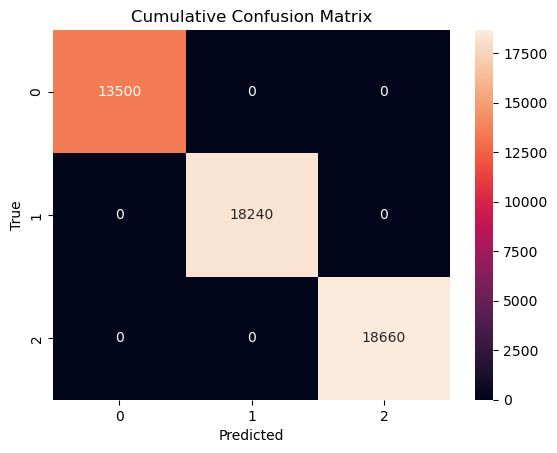

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cumulative_conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cumulative Confusion Matrix')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score
# combine data after k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cumulative_conf_matrix = np.zeros((np.unique(combined_labels_array).size, np.unique(combined_labels_array).size))
accuracy_list = []

# K-Fold 
for train_index_vgg, test_index_vgg in kf.split(vgg_data):
    for train_index_raman, test_index_raman in kf.split(raman_data):
        vgg_train, vgg_test = vgg_data[train_index_vgg], vgg_data[test_index_vgg]
        raman_train, raman_test = raman_data[train_index_raman], raman_data[test_index_raman]

        label_vgg_train = vgg_train[:, -1]
        label_vgg_test = vgg_test[:, -1]
        label_raman_train = raman_train[:, -1]
        label_raman_test = raman_test[:, -1]

        vgg_train_no_label = vgg_train[:, :-1]
        vgg_test_no_label = vgg_test[:, :-1]
        raman_train_no_label = raman_train[:, :-1]
        raman_test_no_label = raman_test[:, :-1]

        # find label
        common_labels_train = np.intersect1d(label_vgg_train, label_raman_train)
        common_labels_test = np.intersect1d(label_vgg_test, label_raman_test)

        combined_train_data = []
        combined_train_labels = []
        for label in common_labels_train:
            rows_vgg = vgg_train_no_label[label_vgg_train == label]
            rows_raman = raman_train_no_label[label_raman_train == label]
            for row_vgg, row_raman in product(rows_vgg, rows_raman):
                combined_train_data.append(np.concatenate([row_vgg, row_raman]))
                combined_train_labels.append(label)

        combined_test_data = []
        combined_test_labels = []
        for label in common_labels_test:
            rows_vgg = vgg_test_no_label[label_vgg_test == label]
            rows_raman = raman_test_no_label[label_raman_test == label]
            for row_vgg, row_raman in product(rows_vgg, rows_raman):
                combined_test_data.append(np.concatenate([row_vgg, row_raman]))
                combined_test_labels.append(label)

        X_train = np.array(combined_train_data)
        y_train = np.array(combined_train_labels)
        X_test = np.array(combined_test_data)
        y_test = np.array(combined_test_labels)

        # RF
        classifier = RandomForestClassifier()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        # 
        conf_matrix = confusion_matrix(y_test, y_pred)
        cumulative_conf_matrix += conf_matrix
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        # report
        print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       560
         1.0       0.40      1.00      0.57       328
         2.0       1.00      0.58      0.73      1200

    accuracy                           0.76      2088
   macro avg       0.80      0.86      0.77      2088
weighted avg       0.90      0.76      0.78      2088
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       840
         1.0       0.99      1.00      0.99       328
         2.0       1.00      0.99      1.00       800

    accuracy                           1.00      1968
   macro avg       1.00      1.00      1.00      1968
weighted avg       1.00      1.00      1.00      1968
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       560
         1.0       0.83      1.00      0.91       984
         2.0       1.00      0.51      0.67       400

    accuracy          

In [43]:
average_accuracy = np.mean(accuracy_list)
print(f"Total Average Accuracy: {average_accuracy * 100:.2f}%")

Total Average Accuracy: 93.82%


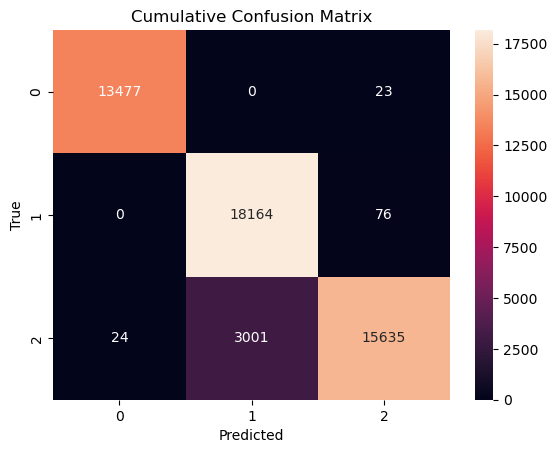

In [44]:
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cumulative Confusion Matrix')
plt.show()